In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import itertools

In [28]:
# ---- Load dataset
data = load_breast_cancer()
X, y = data.data, data.target
class_names = data.target_names  # ['malignant', 'benign']

# ---- Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [29]:
# ---- Pipeline: Standardize -> KNN
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# ---- Hyperparameter search for k and weights
param_grid = {
    "knn__n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15],
    "knn__weights": ["uniform", "distance"]  # distance weighting often helps
}

In [30]:
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    refit=True,
    return_train_score=False
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_
print(f"Best params: {grid.best_params_}")
print(f"CV best accuracy: {grid.best_score_:.4f}")

Best params: {'knn__n_neighbors': 7, 'knn__weights': 'uniform'}
CV best accuracy: 0.9714


In [31]:
# ---- Evaluate on test set
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


Test Accuracy: 0.9737

Classification Report:
              precision    recall  f1-score   support

   malignant       1.00      0.93      0.96        42
      benign       0.96      1.00      0.98        72

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



In [32]:
# ---- Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

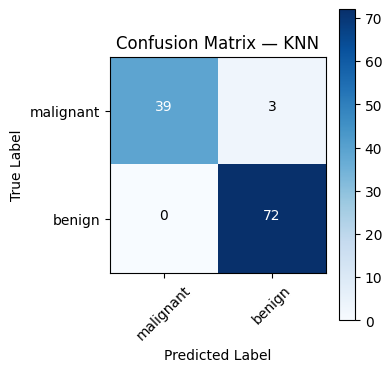

In [33]:
def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

plot_confusion_matrix(cm, class_names, title="Confusion Matrix — KNN")
plt.show()

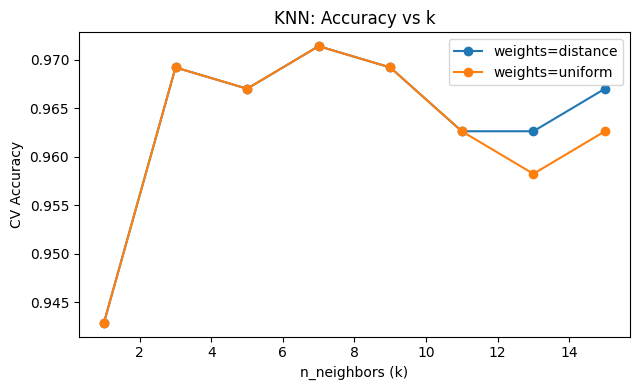

Tip: Try changing the k range, or add 'knn__p' (1=Manhattan, 2=Euclidean) to the grid.


In [34]:
results = grid.cv_results_
ks = sorted(set(results["param_knn__n_neighbors"].data))
weights = sorted(set(results["param_knn__weights"].data))

plt.figure(figsize=(6.5,4))
for w in weights:
    mean_scores = []
    for k in ks:
        mask = (results["param_knn__n_neighbors"] == k) & (results["param_knn__weights"] == w)
        mean_scores.append(np.mean(results["mean_test_score"][mask]))
    plt.plot(ks, mean_scores, marker="o", label=f"weights={w}")

plt.xlabel("n_neighbors (k)")
plt.ylabel("CV Accuracy")
plt.title("KNN: Accuracy vs k")
plt.legend()
plt.tight_layout()
plt.show()

print("Tip: Try changing the k range, or add 'knn__p' (1=Manhattan, 2=Euclidean) to the grid.")